### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re
import gc

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

pd.set_option('display.max_column',100)


/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Import datasets

In [2]:
## switch in GCP co2 emissions up to start of SSPs
page = requests.get('https://data.icos-cp.eu/licence_accept?ids=%5B%226QlPjfn_7uuJtAeuGGFXuPwz%22%5D')
GCP_historical_emissions=pd.read_excel(page.content,-1,skiprows=15,index_col=0,skipfooter=2).iloc[:-2,:2]
GCP_historical_emissions.index = [int(x) for x in GCP_historical_emissions.index]
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'fossil emissions excluding carbonation'] = 0
# set 2020 value to projections
GCP_historical_emissions.loc[2020] = [9.3,1.6]
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'land-use change emissions'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'land-use change emissions']

In [3]:
# Get CEDS emission data
CEDS_sector_files = glob.glob('/home/leachl/Documents/Datasets/Emissions/CEDS/CEDS_v_2020_09_11_emissions/*CEDS_emissions_by_sector_2020_09_11.csv')
CEDS_sector_list = []
for fname in CEDS_sector_files:
    CEDS_sector_list+=[pd.read_csv(fname,index_col=[0,1,2])]

CEDS_sector_data = pd.concat(CEDS_sector_list,axis=0)

# need to remap the sectors in line with primap: see https://github.com/openclimatedata/ceds/blob/master/data/sectors.yaml
CEDS_sector_cats = dict(zip(CEDS_sector_data.index.levels[1].tolist(),[1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,3,5,1,1,1,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,1]))

CEDS_country_files = glob.glob('/home/leachl/Documents/Datasets/Emissions/CEDS/CEDS_v_2020_09_11_emissions/*CEDS_emissions_by_country_2020_09_11.csv')
CEDS_country_list = []
for fname in CEDS_country_files:
    CEDS_country_list+=[pd.read_csv(fname,index_col=[0,1,2])]

CEDS_country_data = pd.concat(CEDS_country_list,axis=0)

CEDS_sector_data.columns = [int(x[1:]) for x in CEDS_sector_data.columns]
CEDS_sector_data = CEDS_sector_data.rename(CEDS_sector_cats,level=1).groupby(level=(0,1,2)).sum().swaplevel(0,1).sort_index()

CEDS_country_data.columns = [int(x[1:]) for x in CEDS_country_data.columns]
CEDS_country_data = CEDS_country_data.rename(dict(zip([x for x in CEDS_country_data.index.levels[1]],[x.upper() for x in CEDS_country_data.index.levels[1]])),level=1).swaplevel(0,1)

## rename species
rename_CEDS = dict(BC='bc',CO='co',NH3='nh3',NMVOC='nmvoc',NOx='nox',OC='oc',SO2='so2')

CEDS_country_data = CEDS_country_data.rename(rename_CEDS,level=1)
CEDS_sector_data = CEDS_sector_data.rename(rename_CEDS,level=1)

In [4]:
# Get PRIMAP emission data
PRIMAP_data = pd.read_csv('/home/leachl/Documents/Datasets/Emissions/PRIMAP-hist/PRIMAP-hist_v2.1_09-Nov-2019.csv',index_col=[0,1,2,3,4]).loc['HISTTP']
PRIMAP_data.columns = [int(x) for x in PRIMAP_data.columns]

PRIMAP_sector_data = PRIMAP_data.loc[('EARTH',['IPC1','IPC2','IPCMAG','IPC4','IPC5'],['CO2','CH4','N2O','HFCS','PFCS','NF3','SF6']),:].droplevel((0)).rename(dict(zip(['IPC1','IPC2','IPCMAG','IPC4','IPC5'],[1,2,3,4,5]))).sort_index()
PRIMAP_country_data = PRIMAP_data.xs('IPCM0EL',level=1).loc[(slice(None),['CO2','CH4','N2O','HFCS','PFCS','NF3','SF6']),:].sort_index()

## rename species
rename_PRIMAP = dict(CH4='methane',CO2='carbon_dioxide',N2O='nitrous_oxide',HFCS='HFCs',NF3='nf3',PFCS='PFCs',SF6='sf6')

PRIMAP_sector_data = PRIMAP_sector_data.rename(rename_PRIMAP,level=1)
PRIMAP_sector_data = PRIMAP_sector_data.reindex(np.arange(1750,2020),axis=1).interpolate(limit=200,limit_direction='both',limit_area=None,axis=1)

PRIMAP_country_data = PRIMAP_country_data.rename(rename_PRIMAP,level=1)
PRIMAP_country_data = PRIMAP_country_data.reindex(np.arange(1750,2020),axis=1).interpolate(limit=200,limit_direction='both',limit_area=None,axis=1)

In [5]:
# Get ODS data
ODS_files = glob.glob('/home/leachl/Documents/Datasets/Emissions/UNEP_ozone/*.xlsx')
ODS_list = [pd.read_excel(x,index_col=0,header=1) for x in ODS_files]
ODS_keys = [x.split('/')[-1].split('.')[0] for x in ODS_files]
ODS_data = pd.concat(ODS_list,axis=0,keys=ODS_keys).iloc[:,:-2]
ODS_data.columns = ODS_data.columns.astype(int)

In [6]:
## population data
UN_desa_population = pd.read_csv('/home/leachl/Documents/Datasets/Socioeconomic_data/WPP2019_TotalPopulationBySex.csv').set_index('Time').loc[ODS_data.columns,('LocID','PopTotal')].reset_index().set_index(['Time','LocID']).unstack(level=0)
UN_global_total = pd.read_csv('/home/leachl/Documents/Datasets/Socioeconomic_data/WPP2019_TotalPopulationBySex.csv').set_index(['Location','Time']).loc['World','PopTotal']

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
## Get country name / code meta

page = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes')
soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

for sup in table_body.find_all('sup'):
    sup.decompose()

data = []
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values
    
country_id_data_incl_nonsov = pd.DataFrame(data[2:],columns = ['Name','Official Name','Sovreignty','alpha-2','alpha-3','numeric',0,1]).drop([0,1],axis=1).set_index('numeric')
country_id_data_incl_nonsov.loc['004','alpha-2'] = 'AF'
country_id_data = country_id_data_incl_nonsov.loc[country_id_data_incl_nonsov.Sovreignty.isin(['UN member state','UN observer'])]

In [8]:
from fuzzywuzzy import fuzz
## wrangle data into emission proportions
### -> parse categories into specific emissions
### -> estimate sectoral ODS emissions based on country regressions

#### Step 1: convert all country references into alpha-3 codes:
##### CEDS and PRIMAP already done

##### ODS data:
ODS_country_map = pd.Series(index=ODS_data.index.levels[1],name='alpha-3')

for country in ODS_country_map.index:
    try:
        ODS_country_map.loc[country] = country_id_data.loc[[country in x.values for i,x in country_id_data.iterrows()],'alpha-3'].values[0]
    except Exception:
        pass
    
unmatched = ODS_country_map.loc[ODS_country_map.isna()]

for country in unmatched.index:
    scores = np.array([fuzz.ratio(country.lower(),x.lower()) for x in country_id_data.Name.tolist()])
    unmatched.loc[country] = country_id_data['alpha-3'].tolist()[scores.argmax()]
    
## manually match the rest
unmatched.loc[['Congo','Cook Islands','Czech Republic','European Union','Gambia','Niger','Niue','Republic of Moldova','State of Palestine','Sudan']] = ['COG','COK','CZE','EU28','GMB','NER','NIU','MDA','PSE','SDN']

ODS_country_map.loc[unmatched.index] = unmatched.values

## convert ODS index to alpha-3
ODS_data_remap = ODS_data.rename(ODS_country_map.to_dict(),axis=0,level=1)
ODS_data_remap.index.set_names('em',level=0,inplace=True)

## finally reformat into neat array
ODS_country_data = ODS_data_remap.swaplevel(0,1).sort_index()

ODS_sector_data = ODS_data_remap.groupby(level=0).sum().reset_index().sort_index()
ODS_sector_data['sector'] = 2
ODS_sector_data = ODS_sector_data.set_index(['em','sector']).swaplevel(0,1)

## rename species
rename_ODS = dict(Bromochloromethane='BCM',CFCs='CFCs',HBFCs='HBFCs',HCFCs='HCFCs',HFCs='HFCs',Halons='HALONs',carb_tet='carbon_tetrachloride',methyl_bromide='methyl_bromide',methyl_chloroform='ch3ccl3',other_fully_halogenated_cfcs='oCFCs')

ODS_sector_data = ODS_sector_data.rename(rename_ODS,level=1).drop(['BCM','HFCs','oCFCs'],level=1)
ODS_country_data = ODS_country_data.rename(rename_ODS,level=1).drop(['BCM','HFCs','oCFCs'],level=1)

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


#### method for estimating sectoral emissions of ODSs

- All HFC emissions in PRIMAP are in sector 2
- Hence I shall assume all ODS emissions are also in sector 2 (seems reasonable enough)

#### Land-use change enmissions (LULUCF)

- for now exclude from country estimates

In [9]:
# ### Land use change emission proportion estimates:
# FAOSTAT_luc = pd.read_csv('/home/leachl/Documents/Datasets/Socioeconomic_data/FAOSTAT_data_12-29-2020_LUC_by_country.csv')#,usecols=[2,3,9,10,11],index_col=[0,1,2,3])#.unstack(level=2)
# print(FAOSTAT_luc.Element.unique())
# print(FAOSTAT_luc.Item.unique())

In [10]:
# FAOSTAT_luc.loc[(FAOSTAT_luc.Element=='Net emissions/removals (CO2)')&(FAOSTAT_luc.Item=='Land Use total')].set_index(['Area','Year'])['Value'].groupby(level=0).mean()

## Construct parameter ensembles

In [11]:
FULL_probabilities = pd.read_hdf('../Parameter_Sets/NROY_GWI_informed/FULL_member_selection_probabilities.h5')
GWI_constraint = FULL_probabilities>np.random.random(FULL_probabilities.size)

In [12]:
def get_GWI_ensemble_parameters(ensemble_size=10000):

    gas_param_ensemble = []
    thermal_param_ensemble = []
    EXT_forc_sfs = []

    gas_param_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/gas_params*'))
    response_param_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/response_params*'))
    EXT_forc_files = sorted(glob.glob('../Parameter_Sets/NROY_GWI_informed/EXT_forc*'))

    mems_selected=0
    i=0

    while mems_selected <= ensemble_size:

        unconstrained_data = pd.read_pickle(gas_param_files[i])
        mems_constraint = GWI_constraint.reindex(unconstrained_data.columns.levels[0]).replace(False,np.nan).dropna().index
        gas_param_ensemble += [unconstrained_data.reindex(mems_constraint,axis=1,level=0)]
        unconstrained_data = pd.read_pickle(response_param_files[i])
        thermal_param_ensemble += [unconstrained_data.reindex(mems_constraint,axis=1,level=0)]
        unconstrained_data = pd.read_pickle(EXT_forc_files[i])
        EXT_forc_sfs += [unconstrained_data.reindex(mems_constraint,axis=1)]

        mems_selected += mems_constraint.size

        i+=1

    thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
    gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)
    EXT_forc_sfs = pd.concat(EXT_forc_sfs,axis=1)
    
    return gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs

In [13]:
def get_specific_GWI_param_set(chosen_param_sets):
    
    gas_param_ensemble = []
    thermal_param_ensemble = []
    EXT_forc_sfs = []

    while chosen_param_sets:

        start_index = int(chosen_param_sets[0][3:])//10000

        chosen_mems = [x for x in chosen_param_sets if int(x[3:])//10000 == start_index]

        [chosen_param_sets.remove(x) for x in chosen_mems]

        gas_param_data = pd.read_pickle('../Parameter_Sets/NROY_GWI_informed/gas_params_mem'+str(start_index*10000)+'-mem'+str(start_index*10000+9999)+'_default.pkl')
        response_param_data = pd.read_pickle('../Parameter_Sets/NROY_GWI_informed/response_params_mem'+str(start_index*10000)+'-mem'+str(start_index*10000+9999)+'_default.pkl')
        EXT_forc_data = pd.read_pickle('../Parameter_Sets/NROY_GWI_informed/EXT_forc_mem'+str(start_index*10000)+'-mem'+str(start_index*10000+9999)+'_default.pkl')

        gas_param_ensemble += [gas_param_data.reindex(chosen_mems,axis=1,level=0)]
        thermal_param_ensemble += [response_param_data.reindex(chosen_mems,axis=1,level=0)]
        EXT_forc_sfs += [EXT_forc_data.reindex(chosen_mems,axis=1)]

    thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
    gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)
    EXT_forc_sfs = pd.concat(EXT_forc_sfs,axis=1)
    
    return gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs

In [14]:
# start off with 10,000 member ensemble

# gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs = get_GWI_ensemble_parameters(ensemble_size=15000)

chosen_param_sets = [x[0] for x in pd.read_hdf('../../../FaIR_projection_interactive/attribution_experiments/countries/AFG.h5').columns.tolist()]
gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs = get_specific_GWI_param_set(chosen_param_sets)

In [15]:
def run_NROY_standard_ssp(ssp,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs):

    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2020))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    ssp_emms.loc[:2019,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2019].values

    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    
    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']

    ## Natural
    volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
    sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

    ssp_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])

    results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble,show_run_info=False)

    return results

## Tier 1: Attribution to forcing drivers

In [16]:
### step 0: set forcing categories:
default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['other_wmghgs'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['other_wmghgs']]
param_categories['f_gases'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','nf3', 'sf6', 'so2f2','cf4','hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee']
param_categories['f_gases'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['f_gases']]
param_categories['montreal_gases'] = ['carbon_tetrachloride','cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22','halon1202','methyl_bromide', 'methyl_chloride']
param_categories['montreal_gases'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['montreal_gases']]
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['carbon_dioxide'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['carbon_dioxide']]
param_categories['methane'] = ['methane']
param_categories['methane'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['methane']]
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['nitrous_oxide'] = [x for x in forcing_namelist if x.split('|')[0] in param_categories['nitrous_oxide']]
param_categories['kyoto_basket'] = param_categories['methane']+param_categories['nitrous_oxide']+param_categories['carbon_dioxide']+param_categories['f_gases']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['aer'] = param_categories['aci'] + param_categories['ari']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

### invert forcing categories for groupby:
# param_categories_inv = pd.DataFrame(param_categories).reset_index()

In [17]:
param_categories_inv = {}
for key,value in param_categories.items():
    if key in ['f_gases', 'montreal_gases', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o', 'aer', 'bc_on_snow', 'contrails']:
        for species in value:
            param_categories_inv[species] = key

In [18]:
# ## step 1: baseline run

# baseline = run_NROY_standard_ssp('ssp245',gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs)

# baseline_temp = baseline['T']

100%|██████████| 269/269 [00:29<00:00,  9.04 timestep/s]


In [19]:
# ## now remove the forcing impact of each param category:
# ### can always change the categories at the start if desired
# ### decide whether to include indirect forcing too (yes for now)

# attr_temp_list = []

# chosen_cats = ['f_gases', 'montreal_gases', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o', 'aer', 'bc_on_snow', 'contrails']

# for param_cat in chosen_cats:
    
#     print('getting '+param_cat)

#     params_to_reset = param_categories[param_cat]

#     gas_param_ensemble_pert = gas_param_ensemble.copy()

#     for f_param in ['f1','f2','f3']:
#         gas_param_ensemble_pert.loc[f_param].loc[slice(None),params_to_reset]=0

#     pert_run = run_NROY_standard_ssp('ssp245',gas_param_ensemble_pert,thermal_param_ensemble,EXT_forc_sfs)['T']
    
#     attr_temp_list += [baseline_temp-pert_run]

In [20]:
# ## LUC

# EXT_forc_sfs_pert = EXT_forc_sfs.copy()
# EXT_forc_sfs_pert.loc['LUC'] = 0

# pert_run = run_NROY_standard_ssp('ssp245',gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs_pert)['T']
    
# attr_temp_list += [baseline_temp-pert_run]

In [21]:
# ## natural

# EXT_forc_sfs_pert = EXT_forc_sfs.copy()
# EXT_forc_sfs_pert.loc[['volc','sol']] = 0

# pert_run = run_NROY_standard_ssp('ssp245',gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs_pert)['T']
    
# attr_temp_list += [baseline_temp-pert_run]

In [22]:
# ## anthro

# gas_param_ensemble_pert = gas_param_ensemble.copy()

# for f_param in ['f1','f2','f3']:
#         gas_param_ensemble_pert.loc[f_param] = 0
        
# EXT_forc_sfs_pert = EXT_forc_sfs.copy()
# EXT_forc_sfs_pert.loc['LUC'] = 0

# pert_run = run_NROY_standard_ssp('ssp245',gas_param_ensemble_pert,thermal_param_ensemble,EXT_forc_sfs_pert)['T']

# attr_temp_list += [baseline_temp-pert_run]

In [23]:
# attr_temps_forc = pd.concat(attr_temp_list,axis=1,keys=chosen_cats+['LUC','natural','anthropogenic'])

In [24]:
# attr_temps_forc.columns.levels[0]

In [25]:
# (attr_temps_forc['methane']-attr_temps_forc['methane'].loc[1850:1900].mean()).quantile([0.05,0.17,0.5,0.83,0.95],axis=1).T.plot()

In [26]:
# attr_temps_forc.to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/forcing-attributed-temps.h5', key='stage', mode='w')

## Tier 2: Attribution to sectors

In [27]:
## get emissions:

ssp='ssp245'

baseline_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2020))
baseline_emms -= baseline_emms.loc[1750] # emissions relative to 1750 values
baseline_emms.loc[:2019,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2019]

mem_names = gas_param_ensemble.columns.levels[0]
N = gas_param_ensemble.columns.levels[0].size

In [28]:
## aggregate species into categories:
PRIMAP_sector_data.index.levels[1]

category_map = dict(HFCs=[x for x in baseline_emms.columns if x[:3] == 'hfc'],\
                   PFCs=['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','cf4'],\
                   CFCs=[x for x in baseline_emms.columns if x[:3]=='cfc'],\
                   HALONs=[x for x in baseline_emms.columns if x[:5]=='halon'],\
                   HCFCs=[x for x in baseline_emms.columns if x[:4]=='hcfc'])

In [29]:
def run_sectoral_pert(choose_sector,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs):
    
    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    ## Forcing first - only need to add LUC for sector 3
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)

    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']
    
    if choose_sector==3:
        LUC_forc_ensemble.loc[:] = 0

    ## Natural
    volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
    sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

    sectoral_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ## need to apply CO2 reduction to fossil co2 only
    co2_ff = GCP_historical_emissions.loc[1750:2019,'fossil emissions excluding carbonation'].astype(float)
    co2_LUC = GCP_historical_emissions.loc[1750:2019,'land-use change emissions'].astype(float)
    
    sectoral_emms = baseline_emms.copy()
    

    ## adding in CEDS based reductions
    if choose_sector in CEDS_sector_data.index.levels[0]:

        CEDS_sector_proportions = (CEDS_sector_data/(CEDS_sector_data.groupby(level=1).sum())).droplevel(2)

        selected_sector_proportions = CEDS_sector_proportions.loc[choose_sector]

        # remove the proportion attributed to the chosen sector:
        for i,x in selected_sector_proportions.iterrows():
            sectoral_emms.loc[:,i] *= 1-x

        # treat nox_avi only for sector 1
        if choose_sector==1:
            sectoral_emms.loc[:,'nox_avi'] *= 1-selected_sector_proportions.loc['nox']


    ## adding in PRIMAP
    if choose_sector in PRIMAP_sector_data.index.levels[0]:
    
        PRIMAP_sector_proportions = (PRIMAP_sector_data / PRIMAP_sector_data.groupby(level=1).sum()).droplevel(2).replace(np.nan,1)

        selected_sector_proportions = PRIMAP_sector_proportions.loc[choose_sector]
        
        ## co2 first
        co2_ff *= 1-selected_sector_proportions.loc['carbon_dioxide'].values
        
        if choose_sector==3:
            co2_LUC *= 0
            
        sectoral_emms.loc[:,'carbon_dioxide'] = co2_ff+co2_LUC

        for species in ['methane','nitrous_oxide']:
            sectoral_emms.loc[:,species] *= 1-selected_sector_proportions.loc[species]

        ## if sector = 2 then change other categories too
        if choose_sector==2:

            # edit direct species first:
            for species in ['nf3','sf6']:
                sectoral_emms.loc[:,species] *= 1-selected_sector_proportions.loc[species]

            for cat in ['HFCs','PFCs']:
                for species in category_map[cat]:
                    sectoral_emms.loc[:,species] *= 1-selected_sector_proportions.loc[cat]


    ## finally, adding in ODS (which is all sector 2):
    if choose_sector == 2:

        for cat in ['CFCs','HCFCs','HALONs']:
            for species in category_map[cat]:
                sectoral_emms.loc[:,species] *= 0

        for species in ['carbon_tetrachloride','methyl_bromide','ch3ccl3','ch2cl2', 'chcl3', 'methyl_chloride', 'so2f2']:
            sectoral_emms.loc[:,species] *= 0
            
    sectoral_emms_run = pd.concat([sectoral_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])
    
    results = run_GIR(emissions_in=sectoral_emms_run,forcing_in=sectoral_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble,show_run_info=False)

    return results

In [32]:
# sector_temp_list = []
# sector_RF_list = []

# for sector in np.arange(1,6):
#     sector_result = run_sectoral_pert(sector,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs)
#     sector_temp_list += [baseline_temp-sector_result['T']]
#     sector_RF_list += [(baseline['RF']-sector_result['RF']).groupby(axis=1,level=-1).mean().groupby(param_categories_inv,axis=1).sum()]
#     del sector_result
#     gc.collect()
    
# attr_RF_sectors = pd.concat(sector_RF_list,axis=1,keys=[1,2,3,4,5])
# attr_temps_sectors = pd.concat(sector_temp_list,axis=1,keys=[1,2,3,4,5])

KeyboardInterrupt: 

In [31]:
# attr_temps_sectors.to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/sector-attributed-temps.h5', key='stage', mode='w')
# attr_RF_sectors.to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/sector-attributed-meanRFs.h5', key='stage', mode='w')

## Tier 3: Attribution to countries

- excluding LULUCF emissions as attribution seems unclear

In [33]:
## first step: aggregate territories of countries:

non_sovreign_countries = country_id_data_incl_nonsov.loc[(~country_id_data_incl_nonsov.Sovreignty.isin(['UN member state','UN observer'])),'alpha-3'].dropna()

map_country_sovreign = dict(zip(country_id_data_incl_nonsov.loc[non_sovreign_countries.index].Sovreignty.unique(),\
                               ['Finland','United States of America (the)','United Kingdom of Great Britain and Northern Ireland (the)','Antarctica','Netherlands (the)','Norway','Australia','New Zealand','Denmark','France','United Kingdom of Great Britain and Northern Ireland (the)','China','disputed']))

non_sovreign_map_df = pd.DataFrame(non_sovreign_countries).reset_index().set_index('alpha-3')

for alph,num in non_sovreign_map_df.iterrows():
    
    non_sovreign_map_df.loc[alph,'sov'] = map_country_sovreign[country_id_data_incl_nonsov.loc[num.values[0],'Sovreignty']]
    
    if non_sovreign_map_df.loc[alph,'sov']=='disputed':
        non_sovreign_map_df.loc[alph,'sov-alpha3'] = np.nan
        
    else:
        non_sovreign_map_df.loc[alph,'sov-alpha3'] = country_id_data_incl_nonsov.loc[country_id_data_incl_nonsov.Name==non_sovreign_map_df.loc[alph,'sov'],'alpha-3'].values[0]
        
## specific entry for CEDS
non_sovreign_map_df.loc['SRB (KOSOVO)','sov-alpha3'] = 'SRB'

In [34]:
## need to add in actual values for EU28 in ODS -> scale total by member state population

EU28 = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR']

EU_not_in_ODS = list(set(EU28)-set(ODS_country_data.index.levels[0].tolist()))

EU28_pop = UN_desa_population.loc[[int(x) for x in country_id_data_incl_nonsov.loc[country_id_data_incl_nonsov['alpha-3'].isin(EU_not_in_ODS)].index]].reindex()
EU28_pop_prop = (EU28_pop/EU28_pop.sum()).droplevel(0,axis=1)

ODS_country_data_noEU = ODS_country_data.copy().drop('EU28')


for country in EU_not_in_ODS:
    
    countryid = int(country_id_data_incl_nonsov.loc[country_id_data_incl_nonsov['alpha-3']==country].index[0])
    country_pop_prop = EU28_pop_prop.loc[countryid]
    for species in ODS_country_data.loc['EU28'].index:
        ODS_country_data_noEU.loc[(country,species),:] = (ODS_country_data.loc[('EU28',species)]*country_pop_prop).values

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


In [35]:
PRIMAP_country_data_agg = PRIMAP_country_data.rename(non_sovreign_map_df['sov-alpha3'].to_dict(),level=0).groupby(level=(0,1,2)).sum().droplevel(2)
PRIMAP_country_data_agg = PRIMAP_country_data_agg.reindex([x for x in PRIMAP_country_data_agg.index.levels[0] if len(x)==3 and x!='LDC'],level=0) # also remove Least developed group

CEDS_country_data_agg = CEDS_country_data.rename(non_sovreign_map_df['sov-alpha3'].to_dict(),level=0).groupby(level=(0,1,2)).sum().droplevel(2)
CEDS_country_data_agg = CEDS_country_data_agg.reindex([x for x in CEDS_country_data_agg.index.levels[0] if len(x)==3],level=0)

In [36]:
## sort out ODS proportions
### maybe use sector 2 co2 emissions per country rather than total co2 emissions:
PRIMAP_sector_2_country_data = PRIMAP_data.loc[(slice(None),['IPC2', 'IPC2A','IPC2B', 'IPC2C', 'IPC2D', 'IPC2G', 'IPC2H']),:].xs('CO2',level=2).groupby(level=0).sum().rename(non_sovreign_map_df['sov-alpha3'].to_dict()).groupby(level=0).sum().reindex([x for x in PRIMAP_country_data_agg.index.levels[0] if len(x)==3 and x!='LDC']).reindex(np.arange(1750,2020),axis=1).interpolate(limit=200,limit_direction='both',limit_area=None,axis=1)

ODS_proportions = []

for species in ['CFCs', 'HALONs', 'HCFCs', 'carbon_tetrachloride', 'ch3ccl3', 'methyl_bromide']:
    
    species_data = ODS_country_data_noEU.xs(species,level=1).rename(non_sovreign_map_df['sov-alpha3'].to_dict()).groupby(level=0).sum()
    country_proportion_estimate = ((PRIMAP_sector_2_country_data.T/PRIMAP_sector_2_country_data.loc[:,1986:1995].mean(axis=1)) * species_data.loc[:,1986:1995].mean(axis=1)).T.dropna()
    ODS_proportions += [country_proportion_estimate / country_proportion_estimate.sum()]

ODS_proportions = pd.concat(ODS_proportions,axis=0,keys=['CFCs', 'HALONs', 'HCFCs', 'carbon_tetrachloride', 'ch3ccl3', 'methyl_bromide']).swaplevel(0,1).sort_index()

In [37]:
## aggregating

PRIMAP_global_total = PRIMAP_country_data_agg.groupby(level=1).sum()+1e-30 # to prevent div by zero errors
CEDS_global_total = CEDS_country_data_agg.groupby(level=1).sum()

In [38]:
def run_country_pert(country,gas_param_ensemble,thermal_param_ensemble,country_forc):
    
    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    ## need to apply CO2 reduction to fossil co2 only
    co2_ff = GCP_historical_emissions.loc[1750:2019,'fossil emissions excluding carbonation'].astype(float)
    co2_LUC = GCP_historical_emissions.loc[1750:2019,'land-use change emissions'].astype(float)
    
    country_emms = baseline_emms.copy()

    ## adding in CEDS based reductions
    if country in CEDS_country_data_agg.index.levels[0]:

        selected_country_proportions = CEDS_country_data_agg.loc[country]/CEDS_global_total

        # remove the proportion attributed to the chosen sector:
        for i,x in selected_country_proportions.iterrows():
            country_emms.loc[:,i] *= 1-x

        # treat nox_avi the same as nox (not a great assumption...)
        country_emms.loc[:,'nox_avi'] *= 1-selected_country_proportions.loc['nox']


    ## adding in PRIMAP
    if country in PRIMAP_country_data_agg.index.levels[0]:

        selected_country_proportions = (PRIMAP_country_data_agg.loc[country] / PRIMAP_global_total).dropna(how='all')
        
        ## co2 first
        if 'carbon_dioxide' in selected_country_proportions.index:
            
            co2_ff *= 1-selected_country_proportions.loc['carbon_dioxide'].values

            country_emms.loc[:,'carbon_dioxide'] = co2_ff+co2_LUC

        for species in ['methane','nitrous_oxide','nf3','sf6']:
            if species in selected_country_proportions.index:
                country_emms.loc[:,species] *= 1-selected_country_proportions.loc[species]

        for cat in ['HFCs','PFCs']:
            if cat in selected_country_proportions.index:
                for species in category_map[cat]:
                    country_emms.loc[:,species] *= 1-selected_country_proportions.loc[cat]


    ## finally, adding in ODS:
    if country in ODS_proportions.index.levels[0]:
        
        selected_country_proportions = ODS_proportions.loc[country]

        for cat in ['CFCs','HCFCs','HALONs']:
            if cat in selected_country_proportions.index:
                for species in category_map[cat]:
                    country_emms.loc[:,species] *= 1-selected_country_proportions.loc[cat]

        for species in ['carbon_tetrachloride','methyl_bromide','ch3ccl3']:
            if species in selected_country_proportions.index:
                country_emms.loc[:,species] *= 1-selected_country_proportions.loc[species]
            
    ## remaining species are: ['ch2cl2', 'chcl3', 'methyl_chloride', 'so2f2'] -> scale as sector 2 CO2
    
    if country in PRIMAP_sector_2_country_data.index:
        
        selected_country_proportions = PRIMAP_sector_2_country_data.loc[country] / PRIMAP_sector_2_country_data.sum()
    
        for species in ['ch2cl2', 'chcl3', 'methyl_chloride', 'so2f2']:
            country_emms.loc[:,species] *= 1-selected_country_proportions
            
    country_emms_run = pd.concat([country_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])
    
    results = run_GIR(emissions_in=country_emms_run,forcing_in=country_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble,show_run_info=False)

    return results

In [39]:
## create external forcing for country attribution (since it is unchanging between countries):

ssp='ssp245'

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)

## LUC
LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']

## Natural
volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2020))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

country_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

In [41]:
contries_to_analyse = list(set(PRIMAP_country_data_agg.index.levels[0].tolist()).intersection(CEDS_country_data_agg.index.levels[0].tolist()))

for country in contries_to_analyse:
    country_run = run_country_pert(country,gas_param_ensemble,thermal_param_ensemble,country_forc)
    (baseline_temp-country_run['T']).to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/countries/'+country+'.h5', key='stage', mode='w')
    (baseline['RF']-country_run['RF']).groupby(axis=1,level=-1).mean().groupby(param_categories_inv,axis=1).sum().to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/countries/'+country+'_meanRF.h5', key='stage', mode='w')

100%|██████████| 269/269 [00:25<00:00, 10.44 timestep/s]


In [41]:
# baseline_temp.to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/baseline-temps.h5', key='stage', mode='w')

### Redo but for CO2 only:

In [38]:
# def run_country_pert_co2only(country,gas_param_ensemble,thermal_param_ensemble,country_forc):
    
#     mem_names = gas_param_ensemble.columns.levels[0]
#     N = gas_param_ensemble.columns.levels[0].size

#     ## need to apply CO2 reduction to fossil co2 only
#     co2_ff = GCP_historical_emissions.loc[1750:2019,'fossil emissions excluding carbonation'].astype(float)
#     co2_LUC = GCP_historical_emissions.loc[1750:2019,'land-use change emissions'].astype(float)
    
#     country_emms = baseline_emms.copy()

#     ## adding in PRIMAP
#     if country in PRIMAP_country_data_agg.index.levels[0]:

#         selected_country_proportions = (PRIMAP_country_data_agg.loc[country] / PRIMAP_global_total).dropna(how='all')
        
#         ## co2 first
#         if 'carbon_dioxide' in selected_country_proportions.index:
            
#             co2_ff *= 1-selected_country_proportions.loc['carbon_dioxide'].values

#             country_emms.loc[:,'carbon_dioxide'] = co2_ff+co2_LUC

            
#     country_emms_run = pd.concat([country_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])
    
#     results = run_GIR(emissions_in=country_emms_run,forcing_in=country_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble,show_run_info=False)

#     return results

In [39]:
# contries_to_analyse = list(set(PRIMAP_country_data_agg.index.levels[0].tolist()).intersection(CEDS_country_data_agg.index.levels[0].tolist()))

# for country in contries_to_analyse:
#     (baseline_temp-run_country_pert_co2only(country,gas_param_ensemble,thermal_param_ensemble,country_forc)['T']).to_hdf(r'../../../FaIR_projection_interactive/attribution_experiments/countries/'+country+'_co2-only.h5', key='stage', mode='w')

## Diagnostics

In [40]:
test = run_country_pert('PER',gas_param_ensemble,thermal_param_ensemble,country_forc)

100%|██████████| 269/269 [00:41<00:00,  6.49 timestep/s]


## Checking the proportionality (ie. FaIR additivity) of results:
- redo the computations for a single member to check the results make sense

In [36]:
# ## select as single parameter set:
# param_set = gas_param_ensemble.columns.levels[0][0]

# gas_param_test = gas_param_ensemble.reindex([param_set],axis=1,level=0)
# thermal_param_test = thermal_param_ensemble.reindex([param_set],axis=1,level=0)
# EXT_forc_sfs_test = EXT_forc_sfs.reindex([param_set],axis=1)

In [37]:
# baseline_run = run_NROY_standard_ssp('ssp245',gas_param_test,thermal_param_test,EXT_forc_sfs_test)

In [38]:
# sector_temp_list = []

# for sector in np.arange(1,6):
#     sector_temp_list += [baseline_temp-run_sectoral_pert(sector,gas_param_test,thermal_param_test,EXT_forc_sfs_test)]
    
# attr_temps_sectors = pd.concat(sector_temp_list,axis=1,keys=[1,2,3,4,5])

In [39]:
# country_temp_list = []
# country_rf_list = []

# contries_to_analyse = list(set(PRIMAP_country_data_agg.index.levels[0].tolist()).intersection(CEDS_country_data_agg.index.levels[0].tolist()))

# for country in contries_to_analyse:
#     result=run_country_pert(country,gas_param_test,thermal_param_test,EXT_forc_sfs_test)
#     country_temp_list += [baseline_run['T']-result['T']]
#     country_rf_list += [baseline_run['RF']-result['RF']]
    
# attr_temps_countries = pd.concat(country_temp_list,axis=1,keys=contries_to_analyse)
# attr_rf_countries = pd.concat(country_rf_list,axis=1,keys=contries_to_analyse)

## Appendix A: Reversibility of sectoral warming
- Extend original baseline run out into future with constant concentrations & forcing.
- Set emissions / forcing from that sector to 0 in 2020.
- check how much of the peak attributable warming is reversed on several timescales.

#### Sorting out what the future baseline is...
- want to know what proportion of peak sectoral warming is reversible
- constant concentrations run??? (issue with matching up proportions)

In [32]:
# select subset of ensemble:
mem_names = mem_names[np.random.choice(mem_names.size,10000,replace=False)]

gas_param_ensemble = gas_param_ensemble.reindex(mem_names,axis=1,level=0)
thermal_param_ensemble = thermal_param_ensemble.reindex(mem_names,axis=1,level=0)
EXT_forc_sfs = EXT_forc_sfs.reindex(mem_names,axis=1)

In [33]:
## first, run normal sectoral warming up to present.

attr_temps_sectors = pd.read_hdf('../../../FaIR_projection_interactive/attribution_experiments/sector-attributed-temps.h5').reindex(mem_names,axis=1,level=1)

In [34]:
def run_sectoral_pert_reversible(choose_sector,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs):
    
    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    ## Forcing first - only need to add LUC for sector 3
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)

    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2320))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']
    
    if choose_sector!=3:
        LUC_forc_ensemble.loc[:] = 0
    else:
        LUC_forc_ensemble.loc[2020:] = 0

    sectoral_forc = pd.concat([LUC_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ## need to apply CO2 reduction to fossil co2 only
    co2_ff = GCP_historical_emissions.loc[1750:2019,'fossil emissions excluding carbonation'].astype(float)
    co2_LUC = GCP_historical_emissions.loc[1750:2019,'land-use change emissions'].astype(float)
    
    sectoral_emms = baseline_emms.copy()

    ## adding in CEDS based reductions
    if choose_sector in CEDS_sector_data.index.levels[0]:

        CEDS_sector_proportions = (CEDS_sector_data/(CEDS_sector_data.groupby(level=1).sum())).droplevel(2)

        selected_sector_proportions = CEDS_sector_proportions.loc[choose_sector]

        # remove the proportion attributed to the chosen sector:
        for i,x in selected_sector_proportions.iterrows():
            sectoral_emms.loc[:,i] *= x

        # treat nox_avi only for sector 1
        if choose_sector==1:
            sectoral_emms.loc[:,'nox_avi'] *= selected_sector_proportions.loc['nox']


    ## adding in PRIMAP
    if choose_sector in PRIMAP_sector_data.index.levels[0]:
    
        PRIMAP_sector_proportions = (PRIMAP_sector_data / PRIMAP_sector_data.groupby(level=1).sum()).droplevel(2).replace(np.nan,1)

        selected_sector_proportions = PRIMAP_sector_proportions.loc[choose_sector]
        
        ## co2 first
        co2_ff *= selected_sector_proportions.loc['carbon_dioxide'].values
        
        if choose_sector!=3:
            co2_LUC *= 0
            
        sectoral_emms.loc[:,'carbon_dioxide'] = co2_ff+co2_LUC

        for species in ['methane','nitrous_oxide']:
            sectoral_emms.loc[:,species] *= selected_sector_proportions.loc[species]

        ## if sector = 2 then change other categories too
        if choose_sector==2:

            # edit direct species first:
            for species in ['nf3','sf6']:
                sectoral_emms.loc[:,species] *= selected_sector_proportions.loc[species]

            for cat in ['HFCs','PFCs']:
                for species in category_map[cat]:
                    sectoral_emms.loc[:,species] *= selected_sector_proportions.loc[cat]


    ## finally, adding in ODS (which is all sector 2):
    if choose_sector != 2:

        for cat in ['CFCs','HCFCs','HALONs']:
            for species in category_map[cat]:
                sectoral_emms.loc[:,species] *= 0

        for species in ['carbon_tetrachloride','methyl_bromide','ch3ccl3','ch2cl2', 'chcl3', 'methyl_chloride', 'so2f2']:
            sectoral_emms.loc[:,species] *= 0
            
    sectoral_emms_run = pd.concat([sectoral_emms.reindex(np.arange(1750,2320)).replace(np.nan,0)]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])
    
    results = run_GIR(emissions_in=sectoral_emms_run,forcing_in=sectoral_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble,show_run_info=False)

    return results

In [35]:
sector_temp_list = []

for sector in np.arange(1,6):
    sector_temp_list += [run_sectoral_pert_reversible(sector,gas_param_ensemble,thermal_param_ensemble,EXT_forc_sfs)['T']]
    
attr_temps_sectors_reverse = pd.concat(sector_temp_list,axis=1,keys=[1,2,3,4,5])

100%|██████████| 569/569 [00:38<00:00, 14.97 timestep/s]


In [36]:
sector_reversibility_proportion = (attr_temps_sectors_reverse.loc[2019:] / attr_temps_sectors_reverse.loc[2019])
sector_reversibility_absolute = (attr_temps_sectors_reverse.loc[2019:] - attr_temps_sectors_reverse.loc[2019])

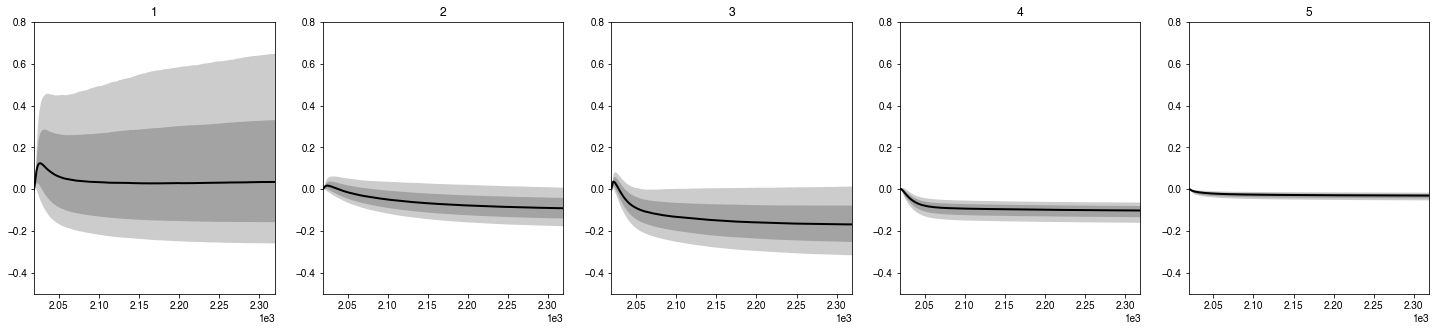

In [37]:
fig,axes = plt.subplots(1,5,figsize=(25,5))

for i,ax in enumerate(axes):
    ax.plot(sector_reversibility_absolute[i+1].median(axis=1),color='k',lw=2)
    ax.fill_between(sector_reversibility_absolute.index,*sector_reversibility_absolute[i+1].quantile([0.05,0.95],axis=1).values,color='k',alpha=0.2,lw=0)
    ax.fill_between(sector_reversibility_absolute.index,*sector_reversibility_absolute[i+1].quantile([0.17,0.83],axis=1).values,color='k',alpha=0.2,lw=0)
    ax.set_title(str(i+1))
    ax.set_xlim(2019,2319)
    ax.set_ylim(-0.5,0.8)